# Born to slide: mobile origin licensing factors confer resistance to conflicts with RNA polymerase

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S2C

#### Archives:
+ Photobleaching_stalled_RNAP.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Photobleaching_stalled_RNAP.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure2/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure2/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

chromatin not found. Setting default to n/a
cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Photobleaching_stalled_RNAP,1,303,ybbR-LD655-T7,GTP/ATP/CTP,False,n/a,False,passed


### Load segment tables, apply filter & calculate bleaching steps

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    for i in range(5):
        archive.filter_segments()
    archive.calc_bleaching_steps()
    

### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    col_1 = sorted(list({prefix for prefix in archive.prefixes for archive in archive_instances}))
    #inside
    col_2 = 'position_on_dna bleaching_steps initial_intensity lifetime'.split()

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(T7_1_, bleaching_steps), (T7_1_, initial_intensity), (T7_1_, lifetime), (T7_1_, position_on_dna)]
Index: []

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #general columns first
        #this could be generalized with mol prefixes
        df.loc[molecule.uid,'number_t7'] = molecule.params['Number_T7']
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()

        for prefix in molecule.prefixes:
            #mean position
            df.loc[molecule.uid,(prefix,'position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].mean()

            #sometimes bleaching is rejected (reject_bleach_prefix)
            if not 'reject_bleach_'+prefix in molecule.tags:
                #from attribute
                df.loc[molecule.uid,(prefix,'bleaching_steps')] = molecule.bleaching_steps[prefix]

            #take intensity from corrected segment table (intensity in first segment)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = \
            list(filter(lambda seg_df: seg_df.prefix == prefix, molecule.seg_dfs))[0].df.loc[0,'y1']
                

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
       
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [13]:
df.head()

molecule                         T7_1_                             \
properties             bleaching_steps initial_intensity lifetime   
oL2mSgXfMRwq8ydxoxxk38               2      51323.594828      187   
fGeqpZG8f7Lb15u4eHqZTF               2      45897.594059      352   
42kZomYmrxiKUS4HqN6MKU               2      56035.669643      197   
bFTEzuhnGaDeDaT9ooNfZw               2      40418.962264      119   
c81BnJVvdnPY67wqveH7nh               1      15183.763158       21   

molecule                               dna_length   nucleotide number_t7  \
properties             position_on_dna                                     
oL2mSgXfMRwq8ydxoxxk38     3545.299039  35.174034  GTP/ATP/CTP       1.0   
fGeqpZG8f7Lb15u4eHqZTF     3458.473656  35.138594  GTP/ATP/CTP       1.0   
42kZomYmrxiKUS4HqN6MKU     4016.076104  35.588172  GTP/ATP/CTP       1.0   
bFTEzuhnGaDeDaT9ooNfZw     3645.993206  35.709965  GTP/ATP/CTP       1.0   
c81BnJVvdnPY67wqveH7nh     4349.760708  35.748905  GTP/ATP/CTP       1.0   

molecule                    tags  
properties                        
oL2mSgXfMRwq8ydxoxxk38  [accept]  
fGeqpZG8f7Lb15u4eHqZTF  [accept]  
42kZomYmrxiKUS4HqN6MKU  [accept]  
bFTEzuhnGaDeDaT9ooNfZw  [accept]  
c81BnJVvdnPY67wqveH7nh  [accept]

## Figures

### Figure S2C: T7 RNAP bleaching steps

In [14]:
# estimate standard error by bootstrapping

In [15]:
_plot_df = pd.DataFrame(columns=['bleaching_steps'])
protein = 'T7'


_temp_df = pd.DataFrame(data=(pd.melt(df.filter(regex=(protein+"_"),axis=1)
                                      .xs('bleaching_steps',level='properties',axis=1))
                              ['value'].dropna().value_counts(normalize=True).rename('probability').
                              reset_index().sort_values('index')))
_temp_df.columns = ['bleaching_steps','probability']

_plot_df = pd.concat([_plot_df,_temp_df])
_plot_df = _plot_df.convert_dtypes()
_plot_df.reset_index(drop=True,inplace=True)

_plot_df

,bleaching_steps,probability
0,1,0.699670
1,2,0.264026
2,3,0.029703
3,4,0.006601


In [16]:
for row in _plot_df.index:
    bootstrap_data = pd.DataFrame(data=(pd.melt(df.filter(regex=(protein+"_"),axis=1)
                                          .xs('bleaching_steps',level='properties',axis=1))['value'].dropna()))
    bootstrap_data['value'] = bootstrap_data['value'].apply(lambda value: 1 if value == _plot_df.loc[row,'bleaching_steps'] else 0)
    bootstrap_means = bootstrap(bootstrap_data['value'],n_boot=10000)
    _plot_df.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    _plot_df.loc[row,'standard_error'] = np.std(bootstrap_means)
    _plot_df.loc[row,'68_ci_lower'], _plot_df.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    _plot_df.loc[row,'95_ci_lower'], _plot_df.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
_plot_df

,bleaching_steps,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,1,0.699670,0.699581,0.026213,0.673267,0.726073,0.646865,0.749175
1,2,0.264026,0.263710,0.025018,0.237624,0.287129,0.214521,0.313531
2,3,0.029703,0.029662,0.009841,0.019802,0.039604,0.013201,0.049505
3,4,0.006601,0.006588,0.004608,0.003300,0.009901,0.000000,0.016502


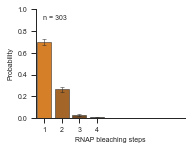

In [21]:
fig,axes = plt.subplots()
protein = 'T7'

sns.barplot(x='bleaching_steps',y='probability',data=_plot_df, lw=0.5, edgecolor='.15', 
            palette=palettes[protein][::2], ax=axes)
axes.errorbar(x=_plot_df.index,y='probability',data=_plot_df, yerr='standard_error',fmt='none',
             ecolor='.15', elinewidth=0.5, capsize=2, capthick=0.5, capstyle='round')

axes.set_xlim(-0.5,8)
axes.set_ylim(0,1)
axes.set_xlabel('RNAP bleaching steps')
axes.set_ylabel('Probability')

axes.text(0.05, 0.95, f"n = {len(pd.melt(df.filter(regex=(protein+'_'),axis=1).xs('bleaching_steps',level='properties',axis=1))['value'].dropna())}",
    verticalalignment='top', horizontalalignment='left',
    transform=axes.transAxes)

#fig.tight_layout()
sns.despine()
# save
plt.savefig(dir_out+'S2C_GAC_loaded_T7_bleaching.svg',transparent=True)
